<a href="https://colab.research.google.com/github/bozorgpanah/The-Explainable-Machine-Learning-Model-withPrivacy/blob/main/Paper1/MDAV_DT_Explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
import scipy
%matplotlib inline

#Define a Artificial Data set comprise 1 million records, 10 variables, 5 informative variables 
X, y = make_classification(n_samples=100, n_features=10, n_redundant=3, n_repeated=2, 
                           n_informative=5, n_clusters_per_class=4, 
                           random_state=42) #for reproducibility 


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
"""
print(X_train,y_train)
print("####################################################################################################")
print(X_test,y_test)
"""

In [ ]:
def dist(x,y):
    return np.linalg.norm(x-y)
    #return scipy.spatial.distance.correlation(x,y)

def poprow(arr,i):
    pop = arr[i]
    new_array = np.vstack((arr[:i],arr[i+1:]))
    return new_array,pop

def cluster(X, p, k, dist_to_xr):
    #c = [p]
    #D = np.column_stack((X,[dist(v[:-1],p[:-1]) for v in X]))
    #D = D[D[:,-1].argsort()]
    #D = np.delete(D, -1, 1)
    #c.extend(D[:k-1])
    #D = D[k-1:]

    #xc = np.array([p[:-1] for p in c], copy=False, ndmin=2)
    #yc = np.array([p[-1] for p in c], copy=False)
    #cl = (xc, yc)
    #return D, cl

    c = [p]
    
    if dist_to_xr == None:
        distances = [dist(v[:-1],p[:-1]) for v in X]
    else:
        distances = dist_to_xr
        
    X = X[np.argpartition(distances, k-1)]
    c.extend(X[:k-1])
    X = X[k-1:]
    
    xc = np.array([p[:-1] for p in c], copy=False, ndmin=2)
    yc = np.array([p[-1] for p in c], copy=False)
    cl = (xc, yc)
    
    return X, cl
    
def mdav(X, y, k):
    D = np.column_stack((X,y))
    clusters = []
    while len(D) >= 3*k:
        # Centroid
        xm = np.mean(D, axis=0)
        # Furthest from centroid
        xri = np.argmax([dist(v[:-1],xm[:-1]) for v in D])
        D, xr = poprow(D, xri)
        # Furthest from furthest from centroid
        dist_to_xr = [dist(v[:-1],xr[:-1]) for v in D]
        xsi = np.argmax(dist_to_xr)
        dist_to_xr = dist_to_xr[:xsi]+dist_to_xr[xsi+1:]
        D, xs = poprow(D, xsi) 

        #cluster of xr
        D, c = cluster(D, xr, k, dist_to_xr)
        clusters.append(c)
        #cluster of xs
        D, c = cluster(D, xs, k, None)
        clusters.append(c)
        
    if len(D) >= 2*k and len(D) < 3*k:
        # Centroid
        xm = np.mean(D, axis=0)
        # Furthest from centroid
        xri = np.argmax([dist(v[:-1],xm[:-1]) for v in D])
        D, xr = poprow(D, xri)
        #cluster of xr
        D, c = cluster(D, xr, k, None)
        clusters.append(c)
        
        # rest of points
        xc = np.array([p[:-1] for p in D[:]], copy=False, ndmin=2)
        yc = np.array([p[-1] for p in D[:]], copy=False)
        cl = (xc, yc)
        clusters.append(cl)     
    else:
        # rest of points
        xc = np.array([p[:-1] for p in D[:]], copy=False, ndmin=2)
        yc = np.array([p[-1] for p in D[:]], copy=False)
        cl = (xc, yc)
        clusters.append(cl)
    
    centroids = np.array([np.mean(c[0],axis=0) for c in clusters], copy=False)
    
    return clusters, centroids

from sklearn import tree
def gen_explanations(clustering, max_depth=-1):
    explanations = []
    for cluster in clustering:
        # Testing with max depth
        if max_depth < 1:
            exp = tree.DecisionTreeClassifier()
        else:
            exp = tree.DecisionTreeClassifier(max_depth=max_depth)
        exp.fit(cluster[0],cluster[1])
        explanations.append(exp) 
    return explanations

def pre_explanations(explanations, centroids, X):
    predictions = []
    for sample in X:
        #select the closest classifier
        exp = explanations[np.argmin([dist(sample,c) for c in centroids])]
        exp_pred = exp.predict([sample])
        predictions.append(int(exp_pred[0]))
    return predictions

def pre_explanations_ext(explanations, centroids, X, T, n):
    predictions = []
    ret_exp = []
    ret_cen = []
    for sample, truth in zip(X,T):
        #select the 3 closest classifiers
        mins = np.array([dist(sample,c) for c in centroids]).argsort()[:n]
        for m in mins:
            exp = explanations[m]
            exp_pred = exp.predict([sample])
            if(exp_pred[0] == truth):
                break
        predictions.append(exp_pred[0])
        ret_exp.append(exp)
        ret_cen.append(centroids[m])
    return predictions, ret_exp, ret_cen

In [ ]:
import time
exec_times = []

# Generate clusters for different representativities
#representativity = [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
representativity = [0.1, 0.5]
K = [int(len(X_train)*r) for r in representativity]
clusterings = []
centroids_of_clusterings = []
for k in K:
    start = time.time()
    
    clustering, centroids = mdav(X_train, y_train, k)
    print(clustering)
    clusterings.append(clustering)
    centroids_of_clusterings.append(centroids)  
    
    end = time.time()
    exec_times.append(end-start)
    display(f'Time for k={k}: {end-start} seconds.')




[(array([[ 2.77610647, -1.71293663, -3.05534354, -4.77202523, -1.01485345,
         2.77610647, -3.69986564,  4.48737083, -1.71293663, -2.74589377],
       [ 1.34274554, -2.51321354, -3.12168494, -2.83643312, -2.06853113,
         1.34274554, -1.38092867,  2.21612046, -2.51321354,  0.75755272],
       [ 2.40735473, -0.86812526, -0.80326739, -0.92499662, -0.09819477,
         2.40735473, -1.08803801,  2.89428308, -0.86812526, -1.38855671],
       [ 1.49020732, -2.05858449, -3.19419413, -2.74463759, -2.03654447,
         1.49020732, -1.75506233,  2.55547839, -2.05858449,  0.39021926],
       [-0.11624756, -0.94778909, -0.83515147, -3.30734003,  0.7519414 ,
        -0.11624756, -1.32139483,  1.13428509, -0.94778909, -1.64421558],
       [ 0.70769419, -1.55961269, -1.31640395, -1.30835807, -0.1762244 ,
         0.70769419, -0.10971937,  1.64549034, -1.55961269,  0.28882915]]), array([0., 1., 1., 1., 0., 1.])), (array([[-4.8631016 ,  2.42495501, -0.71269419,  0.73664693,  0.68747111,
      

'Time for k=6: 0.015604019165039062 seconds.'

[(array([[ 2.77610647, -1.71293663, -3.05534354, -4.77202523, -1.01485345,
         2.77610647, -3.69986564,  4.48737083, -1.71293663, -2.74589377],
       [ 0.70769419, -1.55961269, -1.31640395, -1.30835807, -0.1762244 ,
         0.70769419, -0.10971937,  1.64549034, -1.55961269,  0.28882915],
       [ 1.49020732, -2.05858449, -3.19419413, -2.74463759, -2.03654447,
         1.49020732, -1.75506233,  2.55547839, -2.05858449,  0.39021926],
       [ 2.40735473, -0.86812526, -0.80326739, -0.92499662, -0.09819477,
         2.40735473, -1.08803801,  2.89428308, -0.86812526, -1.38855671],
       [ 0.40812093,  0.46912022, -0.2143914 , -0.69581505, -0.48937274,
         0.40812093, -1.20929403,  0.18364638,  0.46912022, -0.93962056],
       [ 1.34274554, -2.51321354, -3.12168494, -2.83643312, -2.06853113,
         1.34274554, -1.38092867,  2.21612046, -2.51321354,  0.75755272],
       [-0.11624756, -0.94778909, -0.83515147, -3.30734003,  0.7519414 ,
        -0.11624756, -1.32139483,  1.134285

'Time for k=33: 0.014506340026855469 seconds.'

In [ ]:
print(exec_times)

[]


In [ ]:
shallow=False
clu_explanations = []
for clustering in clusterings:
    # Test with shallow trees depht=4
    if shallow:
        explanations = gen_explanations(clustering, 4)
    else:
        explanations = gen_explanations(clustering, -1)
    clu_explanations.append(explanations)

In [ ]:
# Train blackbox model
from sklearn.neural_network import MLPClassifier
blackbox = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001,
                     solver='sgd', verbose=10,  random_state=21,tol=0.000000001)
blackbox.fit(X_train, y_train)

Iteration 1, loss = 0.36259298
Iteration 2, loss = 0.24581898
Iteration 3, loss = 0.21294277
Iteration 4, loss = 0.19200301
Iteration 5, loss = 0.17568969
Iteration 6, loss = 0.16444348
Iteration 7, loss = 0.15690228
Iteration 8, loss = 0.15077435
Iteration 9, loss = 0.14606117
Iteration 10, loss = 0.14222201
Iteration 11, loss = 0.13912586
Iteration 12, loss = 0.13637242
Iteration 13, loss = 0.13414063
Iteration 14, loss = 0.13199409
Iteration 15, loss = 0.13024987
Iteration 16, loss = 0.12856054
Iteration 17, loss = 0.12700290
Iteration 18, loss = 0.12602104
Iteration 19, loss = 0.12463951
Iteration 20, loss = 0.12366419
Iteration 21, loss = 0.12262749
Iteration 22, loss = 0.12173496
Iteration 23, loss = 0.12085035
Iteration 24, loss = 0.12035285
Iteration 25, loss = 0.11947145
Iteration 26, loss = 0.11879139
Iteration 27, loss = 0.11831097
Iteration 28, loss = 0.11753188
Iteration 29, loss = 0.11700097
Iteration 30, loss = 0.11643785
Iteration 31, loss = 0.11635304
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100, 100), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=21, shuffle=True, solver='sgd',
              tol=1e-09, validation_fraction=0.1, verbose=10, warm_start=False)

In [ ]:
#Train big tree
surrogate = tree.DecisionTreeClassifier()
surrogate.fit(X_train,y_train)
display(surrogate.score(X_test, y_test))
display(surrogate.tree_.node_count)

0.9186363636363636

71567

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0229175 to fit



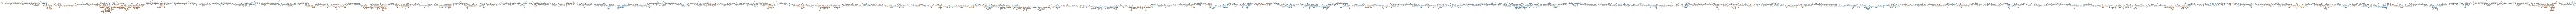

In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(surrogate, out_file=dot_data,  
                filled=True, rounded=True, #feature_names=labels, class_names=['below 50K', 'over 50K'],
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
display(Image(graph.create_png()))

In [ ]:
truth = y_test
blackbox_predictions = blackbox.predict(X_test)
surrogate_predictions = surrogate.predict(X_test)

In [ ]:
explanation_predictions = []
explanation_ext_predictions = []
for i in range(len(clu_explanations)):
    p = pre_explanations(clu_explanations[i], centroids_of_clusterings[i], X_test)
    q,_,_ = pre_explanations_ext(clu_explanations[i], centroids_of_clusterings[i], X_test, blackbox_predictions, 3)
    explanation_predictions.append(p)
    explanation_ext_predictions.append(q)

In [ ]:
# acc = TP+TN/all
acc_blackbox = np.mean([t==p for t,p in zip(truth, blackbox_predictions)])
acc_surrogate = np.mean([t==p for t,p in zip(truth, surrogate_predictions)])
acc_explanations = []
for i in range(len(explanation_predictions)):
    acc_explanations.append(np.mean([t==p for t,p in zip(truth, explanation_predictions[i])]))
    
acc_explanations_ext = []
for i in range(len(explanation_ext_predictions)):
    acc_explanations_ext.append(np.mean([t==p for t,p in zip(truth, explanation_ext_predictions[i])]))

acc_cross = []
for i in range(len(explanation_predictions)):
    acc_cross.append(np.mean([t==p for t,p in zip(blackbox_predictions, explanation_predictions[i])]))

acc_cross_ext = []
for i in range(len(explanation_predictions)):
    acc_cross_ext.append(np.mean([t==p for t,p in zip(blackbox_predictions, explanation_ext_predictions[i])]))

display(acc_blackbox)
display(acc_surrogate)
display(acc_explanations)
display(acc_explanations_ext)
display(acc_cross)
display(acc_cross_ext)

0.9655303030303031

0.9186363636363636

[0.9112454545454546,
 0.9023696969696969,
 0.900309090909091,
 0.894630303030303,
 0.9030121212121213,
 0.9056909090909091,
 0.9023606060606061,
 0.9080666666666667,
 0.9096727272727273]

[0.9593212121212121,
 0.9582484848484848,
 0.9580121212121212,
 0.9575848484848485,
 0.9567848484848485,
 0.9568787878787879,
 0.9567030303030303,
 0.9561424242424242,
 0.955269696969697]

[0.9242363636363636,
 0.9144030303030303,
 0.9126090909090909,
 0.9059909090909091,
 0.9154030303030303,
 0.9177060606060606,
 0.9152545454545454,
 0.9206757575757576,
 0.9227121212121212]

[0.9887,
 0.9874757575757576,
 0.9871606060606061,
 0.9864545454545455,
 0.9859333333333333,
 0.9860939393939394,
 0.985560606060606,
 0.9850363636363636,
 0.9839818181818182]

In [ ]:
min_nodes = []
max_nodes = []
mean_nodes = []
median_nodes = []
n_counts = []
for explanations in clu_explanations:
    node_counts = [exp.tree_.node_count for exp in explanations]
    n_counts.append(node_counts)
    min_nodes.append(np.min(node_counts))
    max_nodes.append(np.max(node_counts))
    mean_nodes.append(np.mean(node_counts))
    median_nodes.append(np.median(node_counts))

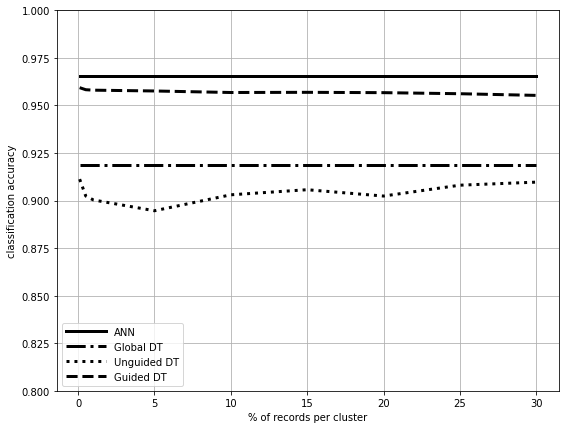

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

representativity = [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
representativity = list([r*100 for r in representativity])
representativity = representativity

xnew = np.linspace(min(representativity),max(representativity),300)
spl = make_interp_spline(representativity, acc_explanations, k=3) #BSpline object
ynew = spl(xnew)

spl = make_interp_spline(representativity, acc_explanations_ext, k=3) #BSpline object
ynew4 = spl(xnew)

acc_blackbox_const = [acc_blackbox]*len(representativity)
spl = make_interp_spline(representativity, acc_blackbox_const, k=3) #BSpline object
ynew2 = spl(xnew)

big_tree = [acc_surrogate]*len(representativity)
spl = make_interp_spline(representativity, big_tree, k=3) #BSpline object
ynew6 = spl(xnew)

spl = make_interp_spline(representativity, acc_cross, k=3) #BSpline object
ynew3 = spl(xnew)

spl = make_interp_spline(representativity, acc_cross_ext, k=3) #BSpline object
ynew5 = spl(xnew)

spl = make_interp_spline(representativity, exec_times, k=3)
ynew7 = spl(xnew)

plt.figure(figsize=(9,7))
#plt.plot(xnew,ynew2,linestyle='-',linewidth=3,color='k',label='ANN')
#plt.plot(xnew,ynew6,linestyle='-.',linewidth=3,color='k',label='Global DT')
#plt.plot(xnew,ynew,linestyle=':',linewidth=3,color='k',label='Unguided DT')
#plt.plot(xnew,ynew4,linestyle='--',linewidth=3,color='k',label='Guided DT')

plt.plot(representativity,acc_blackbox_const,linestyle='-',linewidth=3,color='k',label='ANN')
plt.plot(representativity,big_tree,linestyle='-.',linewidth=3,color='k',label='Global DT')
plt.plot(representativity,acc_explanations,linestyle=':',linewidth=3,color='k',label='Unguided DT')
plt.plot(representativity,acc_explanations_ext,linestyle='--',linewidth=3,color='k',label='Guided DT')

plt.legend(handlelength=4)
plt.ylim(0.8,1)
plt.xlabel('% of records per cluster')
plt.ylabel('classification accuracy')
plt.grid()
plt.show()
plt.close()

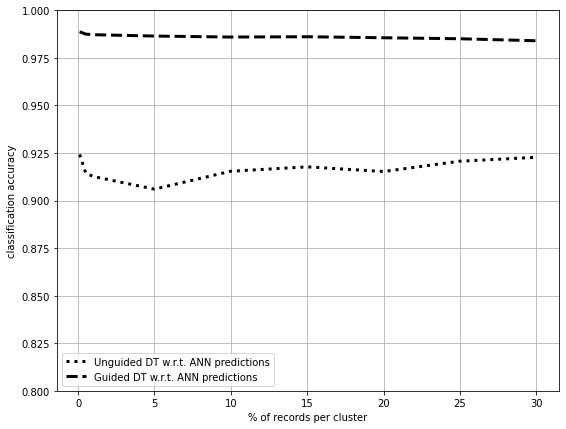

In [ ]:
plt.figure(figsize=(9,7))
#plt.plot(xnew,ynew3,linestyle='-',linewidth=3,color='k',label='Unguided DT w.r.t. ANN predictions')
#plt.plot(xnew,ynew5,linestyle=':',linewidth=3,color='k',label='Guided DT w.r.t. ANN predictions')

plt.plot(representativity,acc_cross,linestyle=':',linewidth=3,color='k',label='Unguided DT w.r.t. ANN predictions')
plt.plot(representativity,acc_cross_ext,linestyle='--',linewidth=3,color='k',label='Guided DT w.r.t. ANN predictions')

plt.legend()
plt.ylim(0.8,1)
plt.xlabel('% of records per cluster')
plt.ylabel('classification accuracy')
plt.grid()
plt.show()
plt.close()

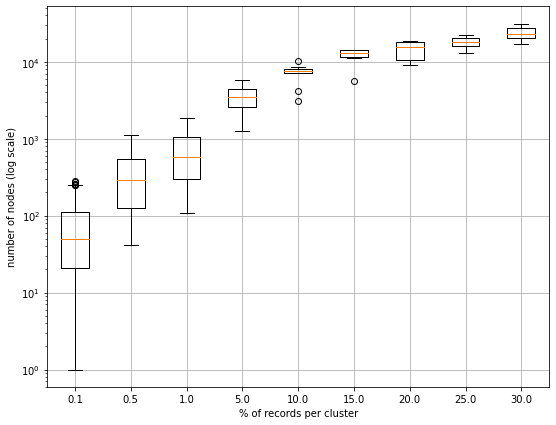

In [ ]:
plt.figure(figsize=(9,7))
plt.boxplot(n_counts[:9])
locs, _ = plt.xticks()
plt.xticks(locs, representativity)
if not shallow:
    plt.yscale('log')
    plt.ylabel('number of nodes (log scale)')
else:
    plt.ylabel('number of nodes')

plt.xlabel('% of records per cluster')
plt.grid()
plt.show()
plt.close()

No handles with labels found to put in legend.


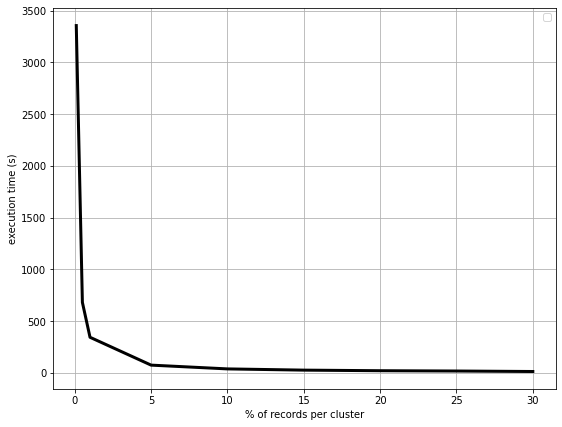

In [ ]:
plt.figure(figsize=(9,7))
plt.plot(representativity,exec_times,linestyle='-',linewidth=3,color='k')

plt.legend()
plt.xlabel('% of records per cluster')
plt.ylabel('execution time (s)')
plt.grid()
plt.show()
plt.close()